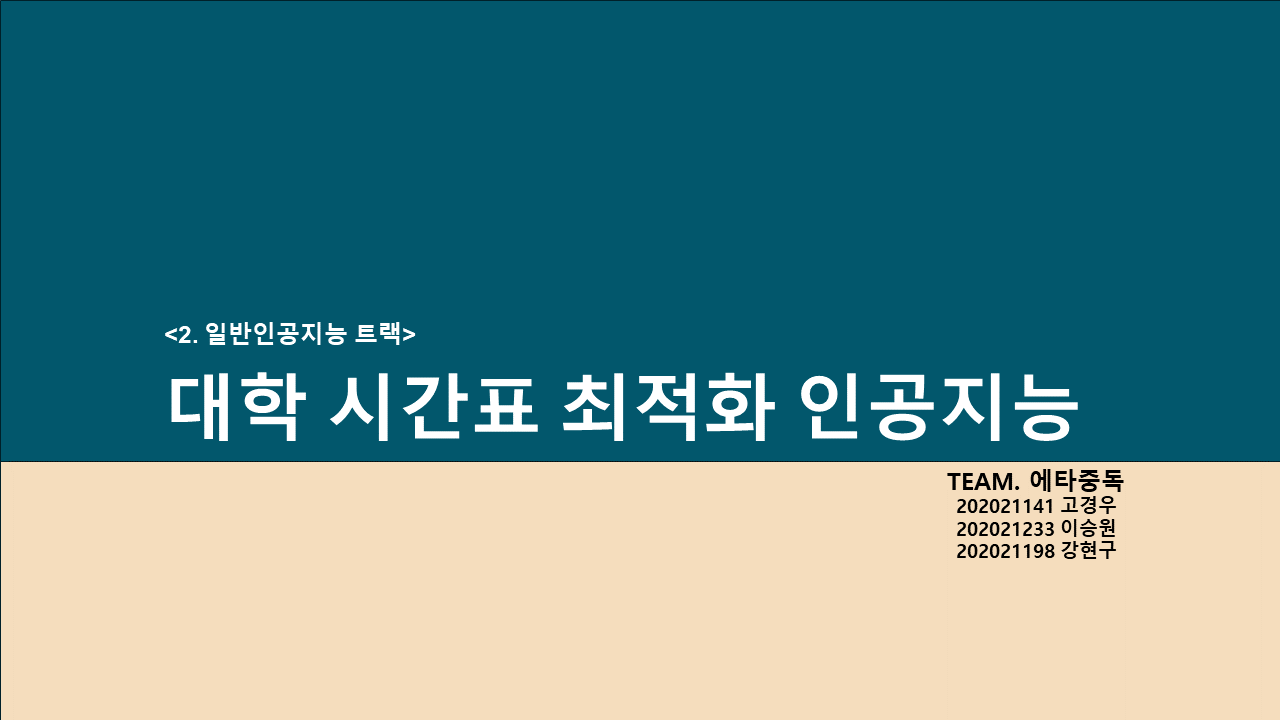

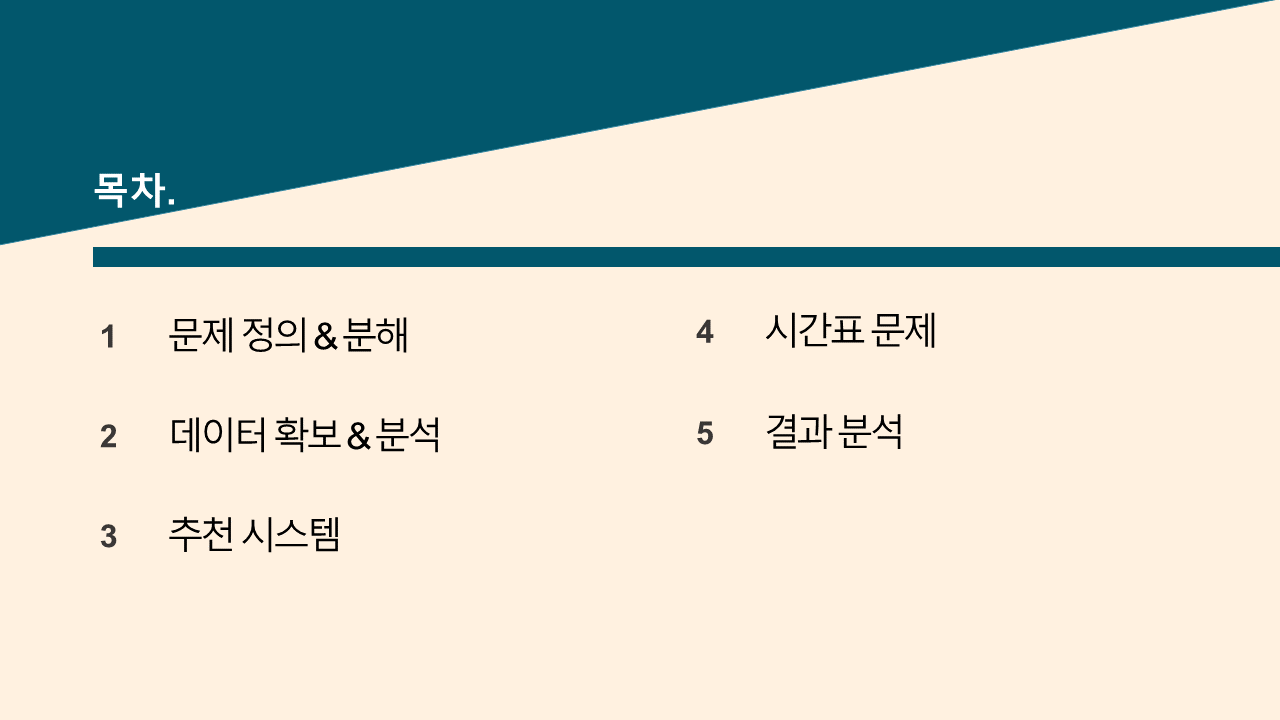

# 트랙 및 주제선정

- 트랙: 데이터를 수집하고 규칙기반 모델부터 딥러닝 모델까지 모든 인공지능 모델을 활용하여 가톨릭대학교 구성원들의 삶을 개선할 수 있는 인공지능 모델 개발

- 주제 : 대학시간표 최적화 인공지능

- 분석 목적 : 대학생들이 시간표를 직접짜는  과정에서 발생하는 시간비용을 최소화하고 졸업요건 미충족 문제를 해결하는데에 있다.


# 문제정의
> 대학생들이 시간표를 직접짜는 과정에서 시간비용이 발생하며 졸업요건을 파악하지 못해 필수적으로 수강해야하는 강의를 누락하는 경우가 발생한다. 이러한 문제를 인공지능모델을 활용하여 시간표를 추천해주는 방법으로 해결하고자 한다.

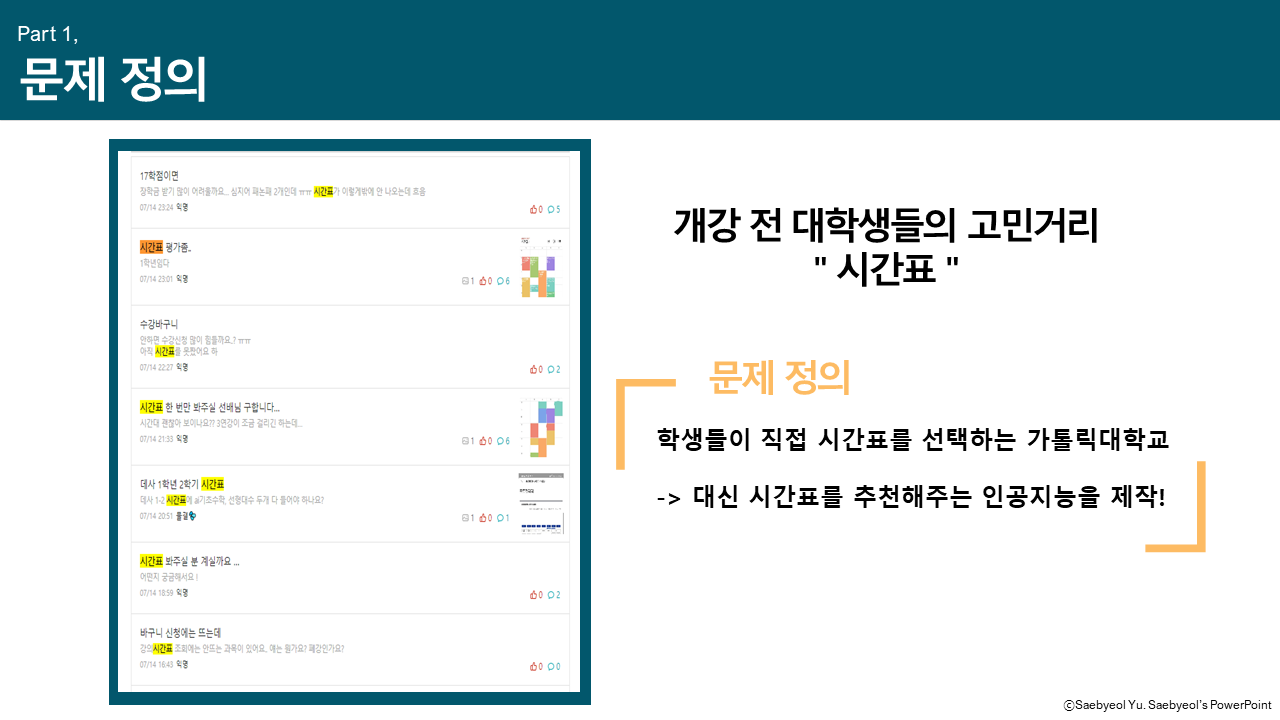

# 문제 분해
<hr>
시간표를 추천하며 만들어주는 알고리즘을 두 가지 과정으로 나누었음

1. 추천 시스템 문제 : 강의별 추천도를 사용자에 맞게 측정하는 과정
2. 시간표 문제 : 강의와 추천도를 가지고 제약조건에 맞춰 배치하는 과정

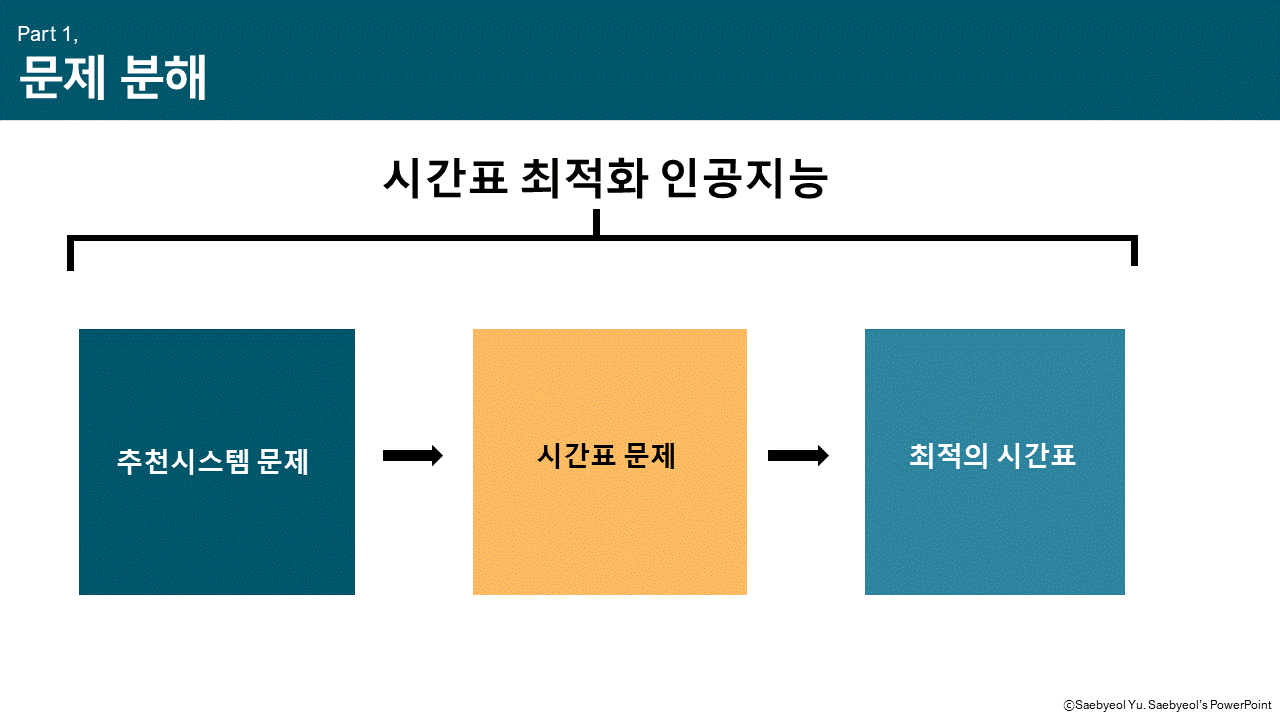

## 추천 시스템 문제
- 강의별 추천도를 계산하는 방법으로서 2가지 모델을 생각해보았다.
- 이는 혼합하여 상호 보완 가능하다.

1. 사용자-강의 간 유사도 측정 : 가톨릭대 학생들의 수강신청 과정을 본떠 사용자-강의간 특성의 유사도를 측정하고 우선도를 매긴다.
2. (가능성) 협업 필터링 : 사용자와 비슷한 특성의 사용자들이 선택한 강의를 머신러닝으로 학습시켜 추천한다.

## 시간표 문제
> 선형계획법을 활용하여 필수제약을 만족하되 최선의 추천도를 가져갈 수 있는 방법을 모색한다.

- 참고로 96년도부터 논문이 존재하는 문제이며 다양한 문제로 해결가능.
- 제약프로그래밍: 가톨릭대학교라는 충분히 특수한 상황에 놓여있기에 제약 조건이 바뀔 가능성이 적기에 채택 x
- 유전 알고리즘: 품질평가가 어렵고 수렴속도가 느릴 것을 예상해 채택 x

따라서 정확한 최적해를 보장하며 속도가 빠른 정수 계획법 채택

# 데이터 확보
<hr>

- 방법: 크롤링
- 라이브러리: (selenium)
- 출처: 가톨릭대 trinity, everytime
- 수집 데이터: 2023년 2학기 강의 예정 강의 목록과 강의평 등

추후 가능성
- 방법 : api
- 출처: 가톨릭대 트리니티
- 수집데이터: 강의별 수강신청 기록정보
- 사용처 : 머신러닝, 딥러닝

'보안서약서 - 비식별화' 절차로 인한 일정문제로 해당 데이터는 더미 데이터로 시연

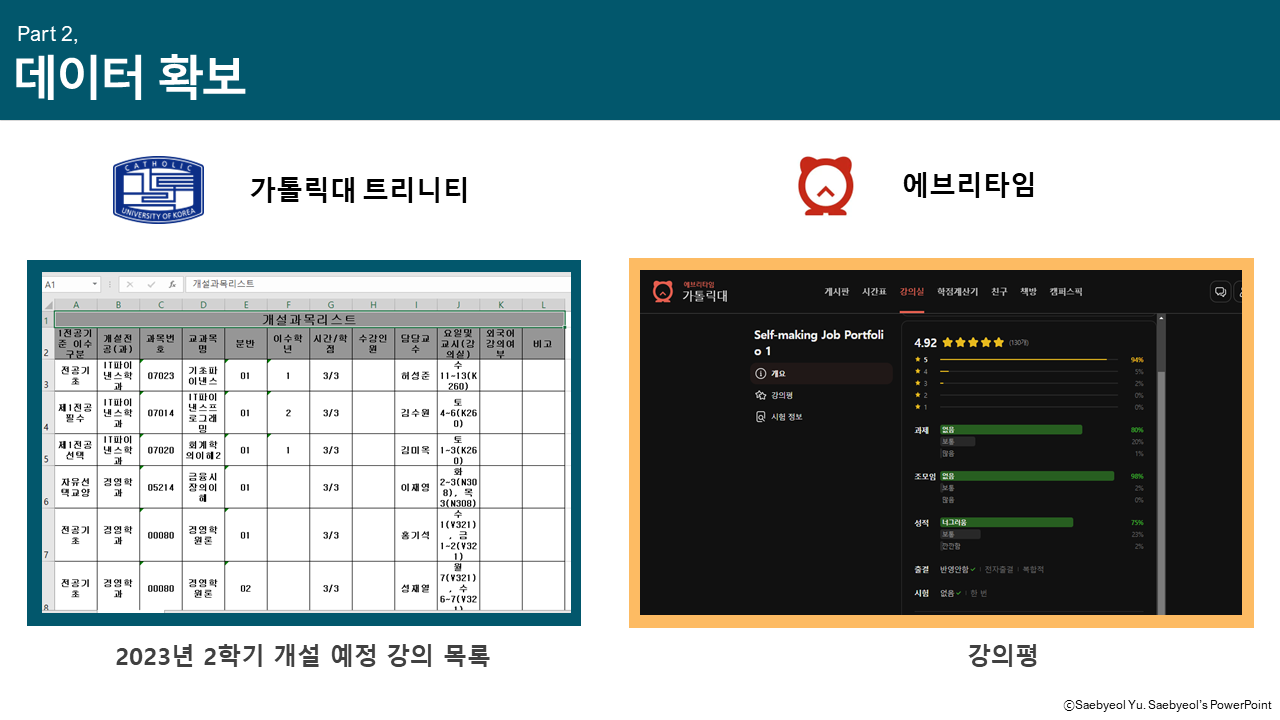

# 데이터 노이즈 제거 및 병합
<hr>

In [ ]:
from google.colab import files # 트리니티 에브리타임 데이터 업로드시 시연가능
uploaded = files.upload()

Saving everytime_2023_2.html to everytime_2023_2.html
Saving Trinity_2023_2.xlsx to Trinity_2023_2.xlsx


In [ ]:
from IPython.utils.text import string
import openpyxl
import os
import random
import csv

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np


# csv 파일로 변환할것

lectures = [] # [["cur", "major", "id", "name", "num", "grade", "credit", "pf", "time", "eng", "score", "want", "hw", "team", "mark", "att", "test"]]
score_base = "0" # 평점이 0일때 조정할 기본값(평가가 없는 강의)

# 랜덤요소
# hw: 과제 1: 없음 0: 보통 -1: 많음
# team: 팀플 1: 없음 0: 보통 -1: 많음
# mark: 채점기준 1: 너그러움 0: 보통 -1: 깐깐함
# att: 출결 반영x : 2 전자출결 : 1 복합적 : 0 지정좌석 : -1 직접호명 : -2
# test: 시험횟수 없음 : 2 한번 : 1 두번 : 0 세번 : -1 네 번이상: -2


##########################
### Trinity_EXEL_FILE ####
##########################

wb = openpyxl.load_workbook("Trinity_2023_2.xlsx", data_only=True)
sheet = wb['개설과목리스트']

for row in range(3, 1286): # 비고항목 제외
    lecture = []
    for column in range(1, 12):
        if column == 8 : continue # 수강인원항목 제외

        # 시간/학점 -> 학점
        if column == 7:
            lecture.append(sheet.cell(row=row, column=column).value[2])

        # 요일및교시 정형화
        elif column == 10:
            time_str = sheet.cell(row=row, column=column).value
            if time_str == '': # 시간표가 정해지지 않은 경우
                lecture.append(time_str)
            else:
                time_str = time_str.split(', ')
                tims = []
                for item in time_str:
                    week = item[0] # 요일
                    if '~' in item:
                        start = int(item[1:item.find('~')]) # 시작시간
                        end = int(item[item.find('~')+1:item.find('(')]) # 종료시간
                        for i in range(start, end+1):
                          tims.append(f"{week}{i}")
                    else: #만약 1시간짜리라면 시작시간 = 종료시간
                        tims.append(f"{week}{item[1:item.find('(')]}")
                lecture.append(tims)
        else:
            lecture.append(sheet.cell(row=row, column=column).value)
    lecture.append(score_base) # score자리추가
    lecture.append("0") # want자리추가
    lectures.append(lecture)

############################
### EVERYTIME_HTML_FILE ####
############################

page = open('everytime_2023_2.html', 'rt', encoding='utf-8').read() # HTML read to String
soup = BeautifulSoup(page, 'html.parser') # BS 객체 생성

scores = [] #[id, num, score, want]

for tr in soup.select('tr'):
    temp = list(tr)[0].get_text()
    if (temp == "" or 48 > ord(temp[1]) or ord(temp[1]) > 57): continue # 잘못된 입력값 예외처리
    id = temp[:temp.find('-')]

    num = temp[temp.find('-')+1:]

    want = list(tr)[9].get_text()

    star = tr.select_one('a')['title']
    if star == '0':
        star = score_base
    scores.append([id, num, star, want])

for score in scores:
    for lecture in lectures:
        if lecture[2] == score[0] and lecture[4] == score[1]: # id와 num 비교
            lecture[10] = score[2] # score
            lecture[11] = score[3] # want



####################
### RANDOM_VALUE ###
####################

for lecture in lectures:
    if lecture[10] == score_base: # 강의평이 없는 경우
        for i in range(5):
            lecture.append("")

    else:
        lecture.append(random.randrange(-1, 2))
        lecture.append(random.randrange(-1, 2))
        lecture.append(random.randrange(-1, 2))
        lecture.append(random.randrange(-2, 3))
        lecture.append(random.randrange(-2, 3))

##################
### CSV_WRITER ###
##################

f = open('data.csv', 'w', newline='')
wr = csv.writer(f)
wr.writerow(["cur", "major", "id", "name", "num", "grade", "credit", "pf", "time", "eng", "score", "want", "hw", "team", "mark", "att", "test"])
wr.writerows(lectures)

f.close()

print("complete")


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


complete


## 데이터 특성 정리
#### 강의 특성
- id: 과목번호
- name: 교과목명
- num: 분반
- cur: 전공이수구분
- major: 개설전공
- grade: 이수학년  (0 인경우와 빈경우가 있음)
- credit: 학점 (시간이 0인경우존재 + time도 비어있음)
- pf: 담당교수 (비어있는 경우 다수)
- time: 요일 및 교시 - [요일(월\~토), 시작시간(1\~14), 종료시간(1~14)] = 리스트로 구성, 분할된 경우 2개의 리스트로 구성 (비어있는경우 다수)
- eng: 외국어 강의 여부 (비어있는 경우 다수)
- score: 에타 강의평점 (미평가 = 0점)
- want: 수강바구니

랜덤요소 (에타로 구할 수는 있으나 구하기 힘든 데이터)
- hw: 과제 1: 없음 0: 보통 -1: 많음
- team: 팀플 1: 없음 0: 보통 -1: 많음
- mark: 채점기준 1: 너그러움 0: 보통 -1: 깐깐함
- att: 출결 반영x : 2 전자출결 : 1 복합적 : 0 지정좌석 : -1 직접호명 : -2
- test: 시험횟수 없음 : 2 한번 : 1 두번 : 0 세번 : -1 네 번이상: -2

##### 사용자 특성
- grade : 학년
- essential  : 학년과 학번, 학기에 알맞는 필수 이수 강의 목록(
- major : 전공 (복수전공생의 경우 2개, 계열생은 나중에 고려)
- taked : 수강완료한 강의목록

# 데이터 분석(통계)
<hr>

## 수강바구니(에타기준) 신청 인원 - target
- 강의를 실제로 학생들이 시간표에 추가하고 싶다고 희망한 수치로서, 추천 시스템에 있어 target에 가깝다. 그러나 학기가 시작될 쯤 트리니티의 정보를 바탕으로 시간표를 업데이트 -> 에타에서 학생들이 수강희망 시간표를 작성하는 과정을 바탕으로 만들어지기에 상당히 늦다. 따라서 이전학기까지의 데이터를 기반으로 하는 다른 특성이 필요하다.

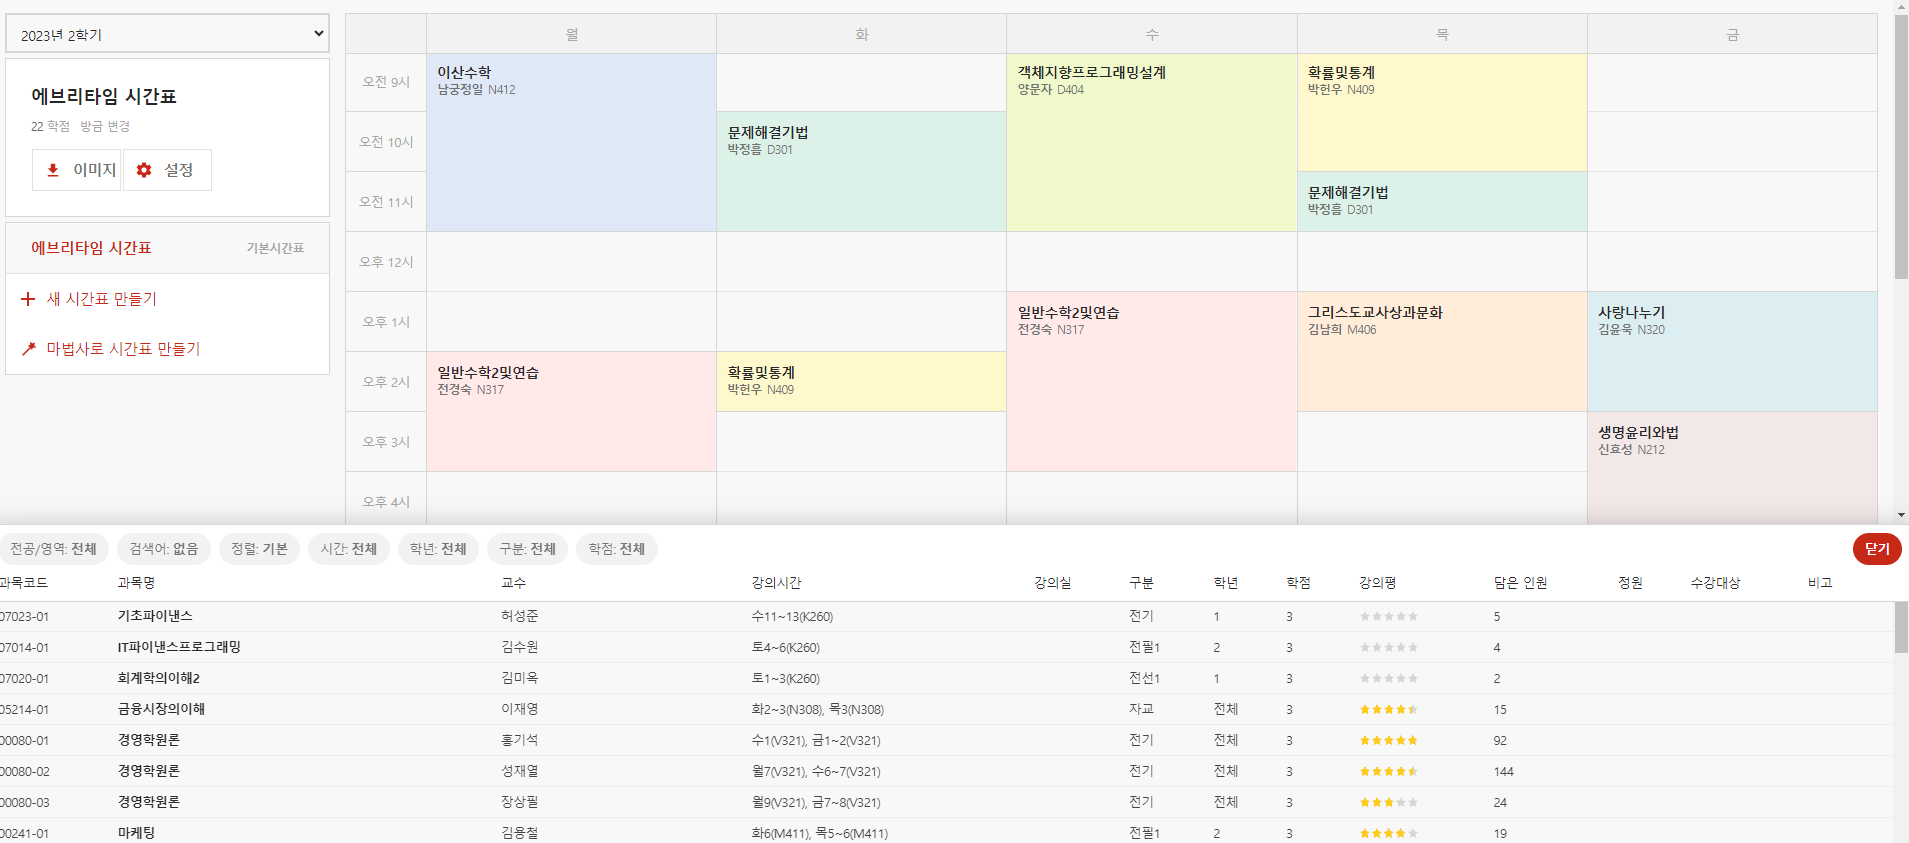

## 강의평(별점) - Explicit feedback
- 수강한 학생들이 남기는 데이터로서 전공과목에 경우 동일한 과 & 비슷한 시기(즉 이수학년) 학생들 위주의 명백한 평가(Explicit feedback)
- 수강바구니 인원과 달리 이전학기까지의 데이터로 이루어짐
- 특성으로 선택 전 이번학기 수강바구니 신청 인원 - 강의평 간의 관계성을 검증할 필요가 있음

### 강의평(별점)과 수강바구니 간 관계성 검증

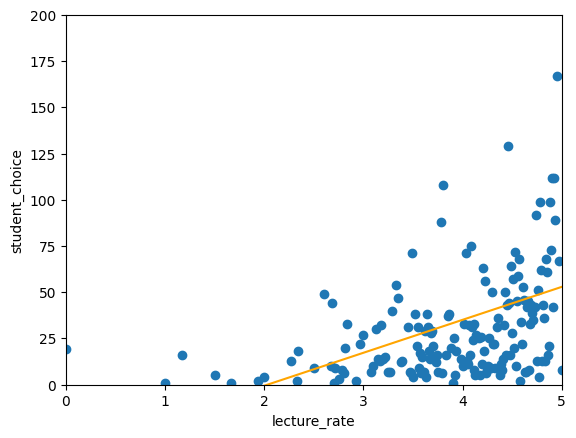

In [ ]:
# 강의평(별점) - 학생들의 수강바구니 신청수 분포도
lectures.sort(key=lambda x : float(x[10]))
dic = {} # star: want
for x in lectures:
  if x[10] in dic.keys():
    dic[float(x[10])] += int(x[11])
  else:
    dic[float(x[10])] = int(x[11])
star = list(dic.keys())
want = list(dic.values())

fit_line = np.polyfit(star, want, 1) # input 의미 : x축 데이터, y축 데이터, 1차원

star_minmax = np.array([min(star), max(star)]) # x축 최소값, 최대값
fit_want = star_minmax * fit_line[0] + fit_line[1] # x축 최소, 최대값을 회귀식에 대입한 값

plt.scatter(star, want)
plt.plot(star_minmax, fit_want, color = 'orange') # 회귀선 그래프 그리기
plt.xlabel('lecture_rate')
plt.ylabel('student_choice')
plt.axis([0, 5, 0, 200])
plt.show()


> 모든 강의의 강의평에 따른 수강바구니 신청수를 그래프화 한 것이다. (황색 선: 회귀선)

> 해석: 강의의 규모도 고려해야하지만 강의평과 학생의 수강바구니 선택율이 어느정도 비례함이 검증되었다.

### 강의평이 없는 강의 문제(결측치)
강의평은 위에서 볼 수 있듯 꽤나 유효한 강의특성이다. 그러나 아직 강의평이 없는 경우 값이 0으로 나오기에 이에 대한 보정이 필요하다.

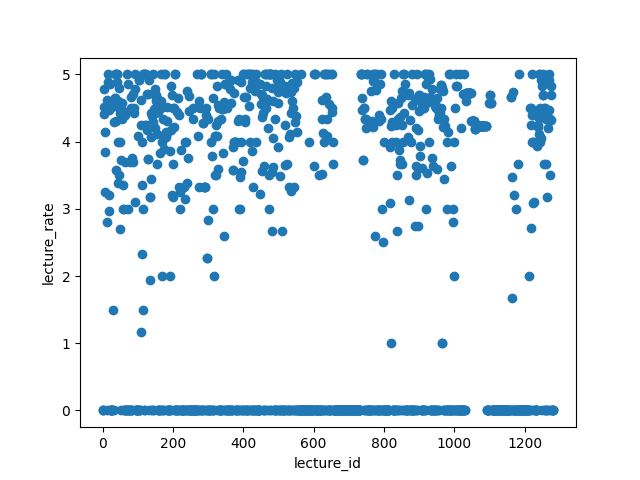
> 강의평 - 강의ID 분포도

#### 다중선형회귀

단순히 모든 강의평에 대한 평균값을 사용할 수도 있지만, 좀 더 유연하게 다양한 강의특성을 반영하는 **다중 선형 회귀**를 활용했다. 반영할 특성과, 모델(선형 회귀, 라쏘회귀, 릿지회귀), 규제강도(alpha)를 비교분석했다.

In [ ]:
!pip install --target=$my_path yfinance itertools # 조합 처리를 위한 라이브러리

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


('major',)
0.11013856403861533
-0.015213359010353145


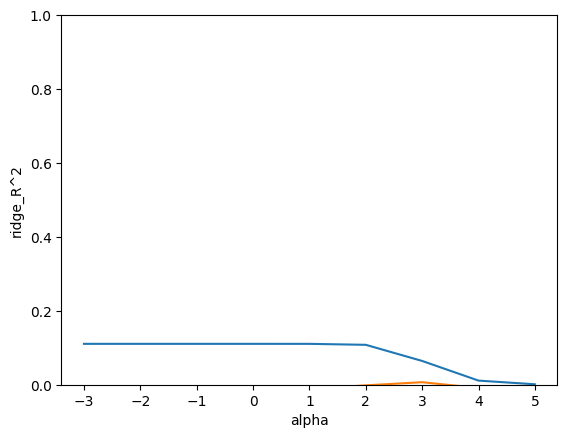

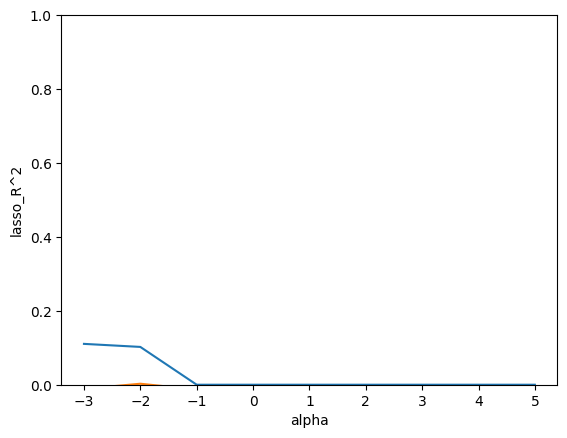

('cur',)
0.019534428572204665
-0.01444476452339405


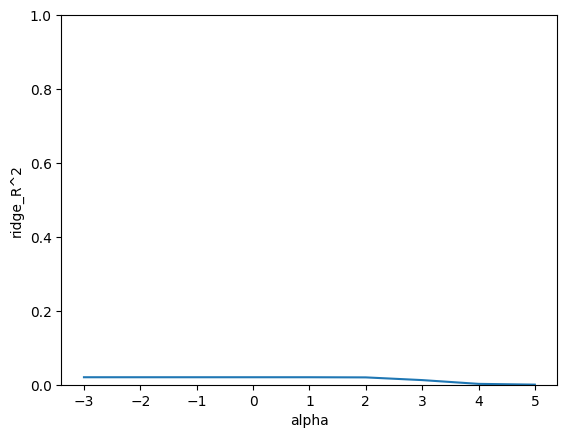

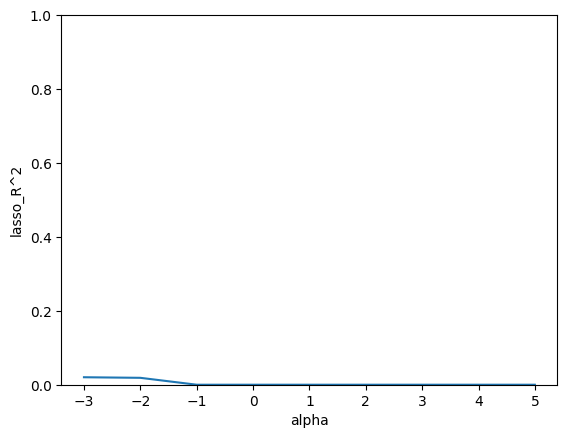

('grade',)
0.0064214764544343605
-0.036770643523707625


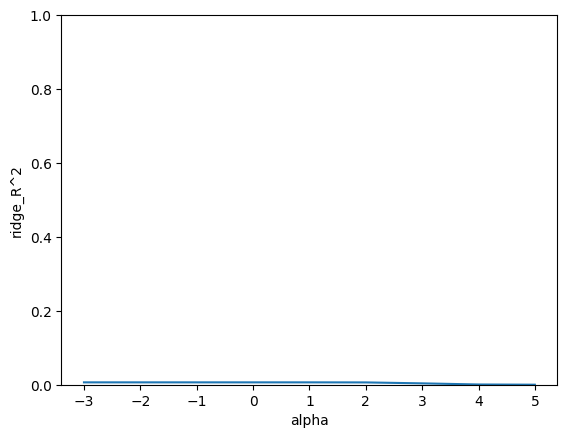

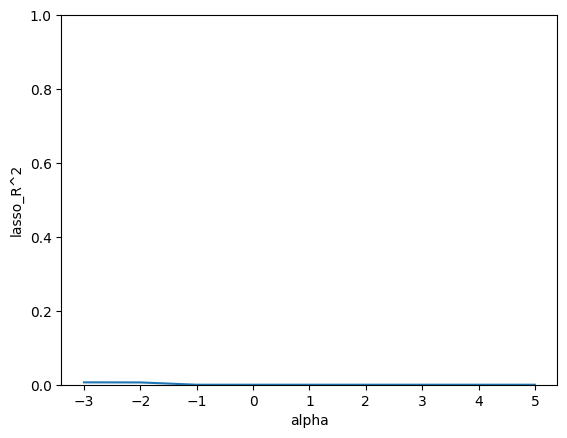

('pf',)
0.6684783901961495
-1.1743778083883589e+27


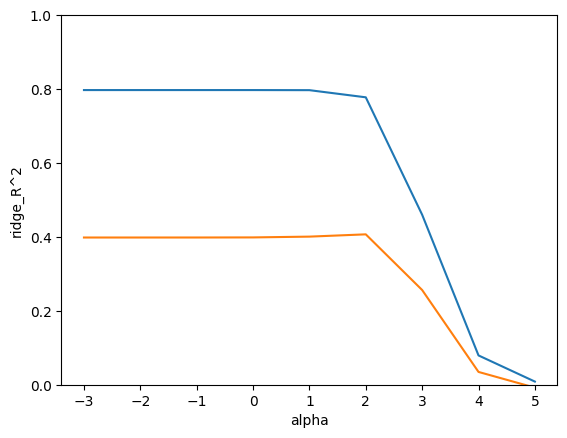

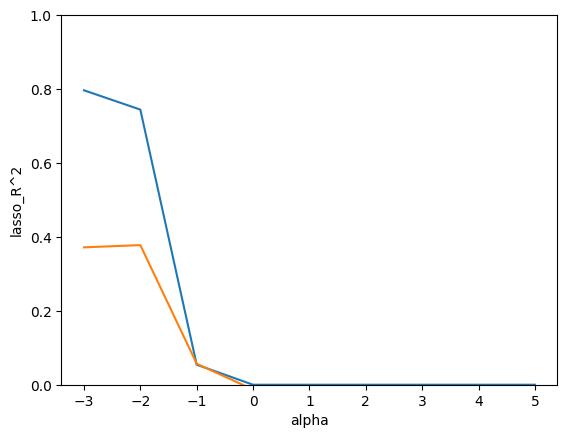

('major', 'cur')
0.13549736464652773
-2.1513757578684e+23


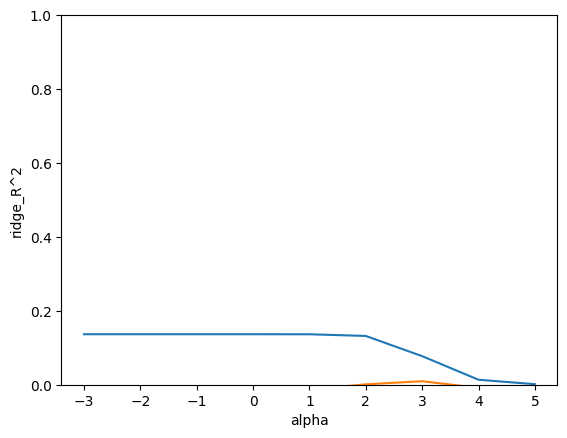

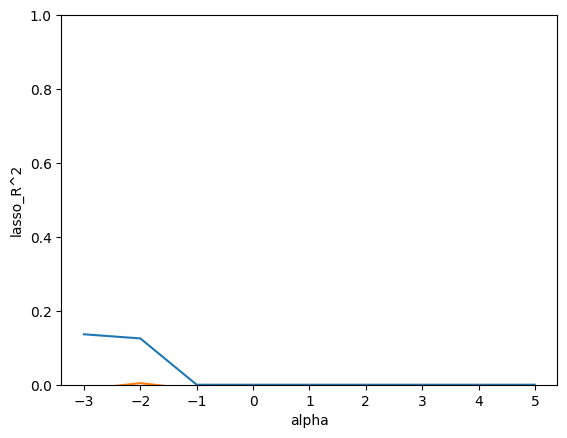

('major', 'grade')
0.11879001152954227
-0.027177982219818153


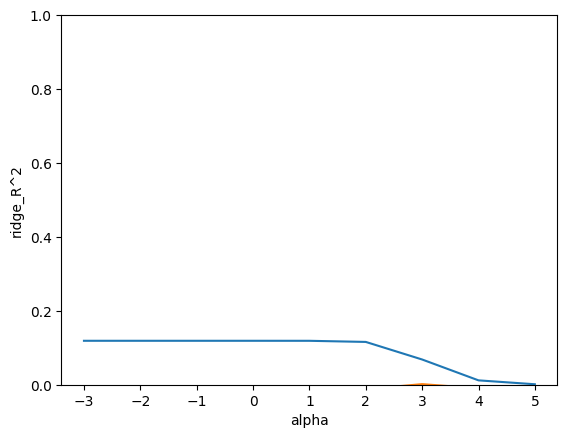

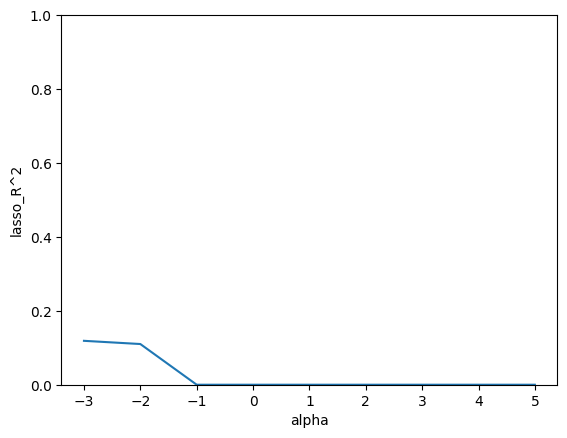

('major', 'pf')
0.4203200982359431
-8.627840686643785e+27


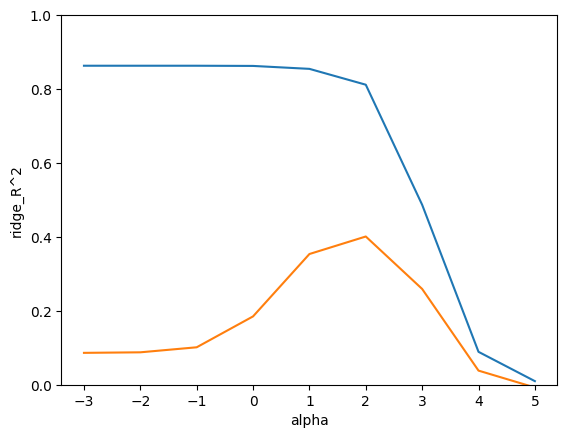

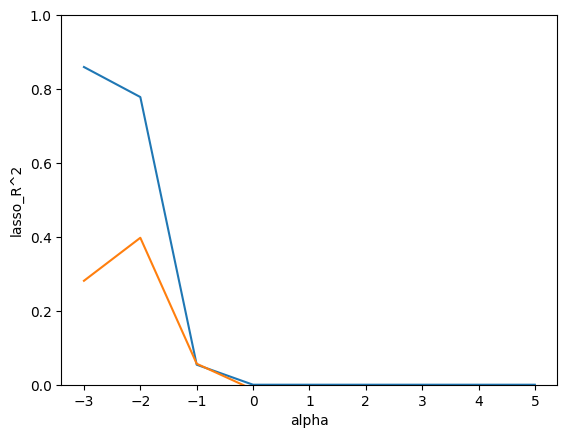

('cur', 'grade')
0.01668309509660637
-0.008969772478178761


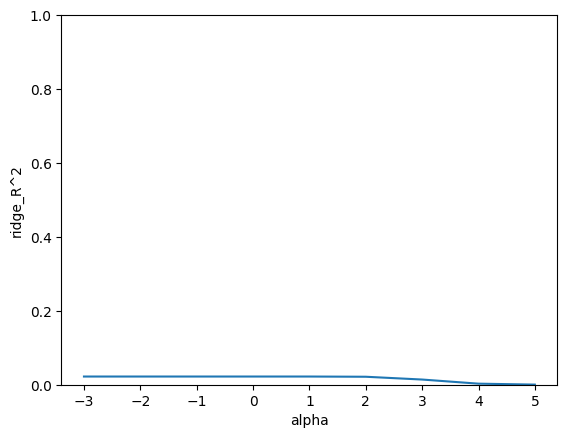

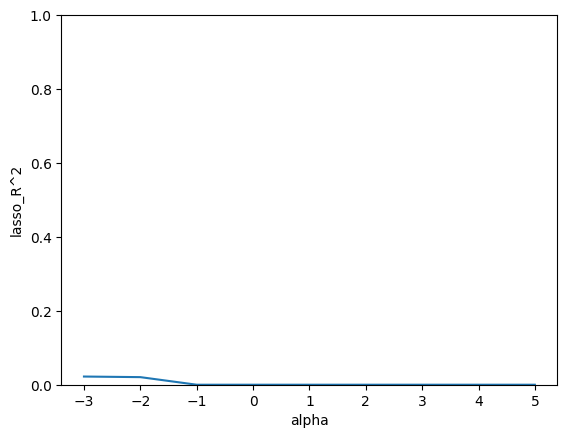

('cur', 'pf')
0.7927331595422382
-1.550374522089611e+27


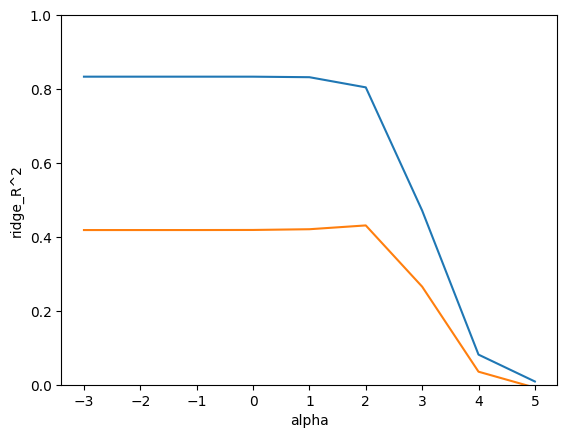

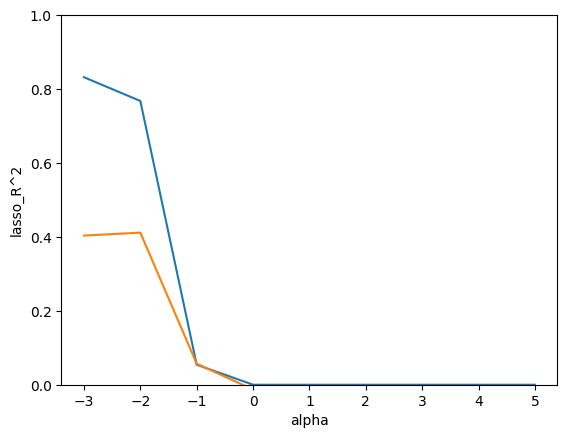

('grade', 'pf')
0.5697723798584327
-4.8035435236508094e+26


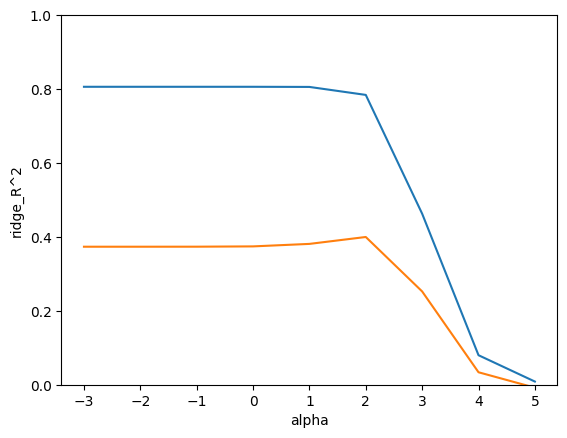

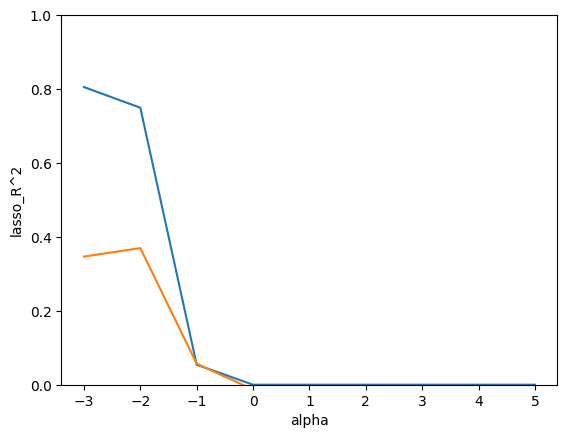

('major', 'cur', 'grade')
0.13500720348394546
-2.6430888646799475e+25


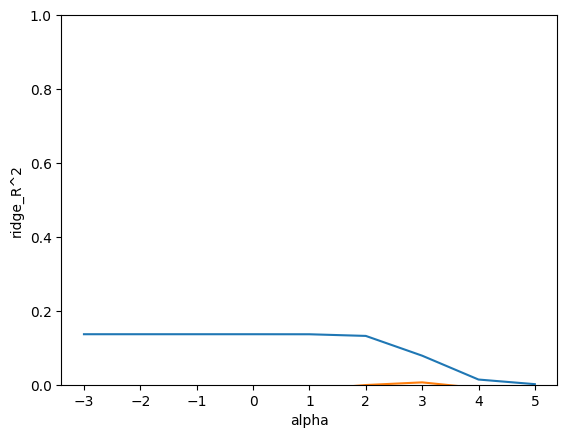

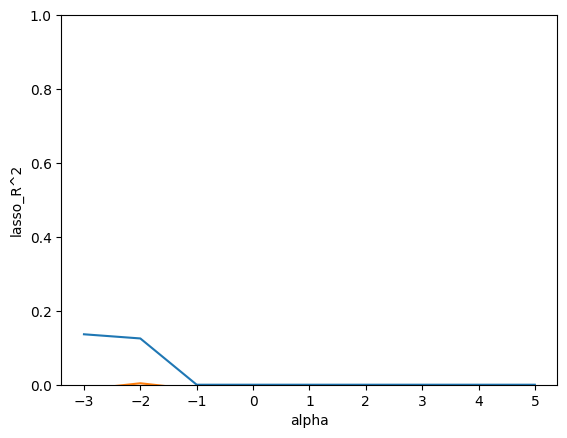

('major', 'cur', 'pf')
0.24128725852039
-7.826361789528333e+27


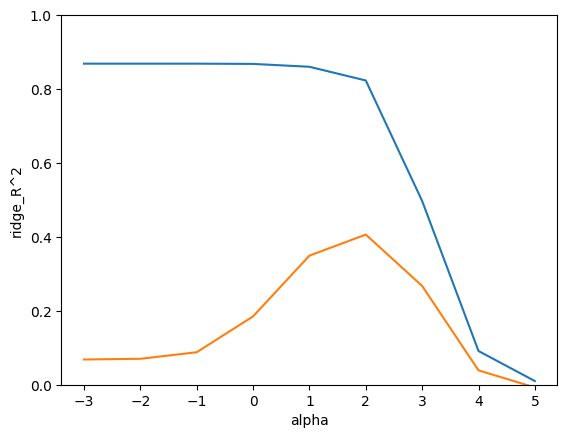

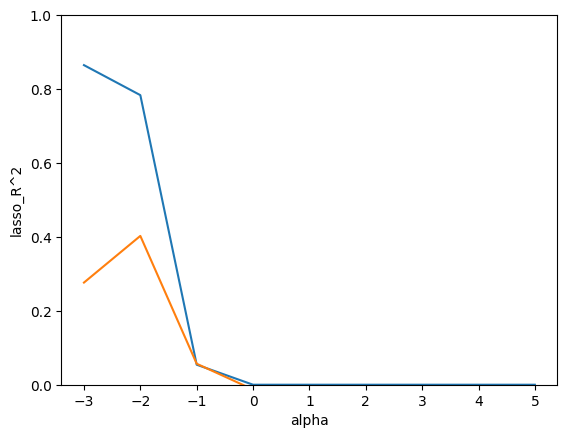

('major', 'grade', 'pf')
0.5708610395691447
-1.4855784778184754e+28


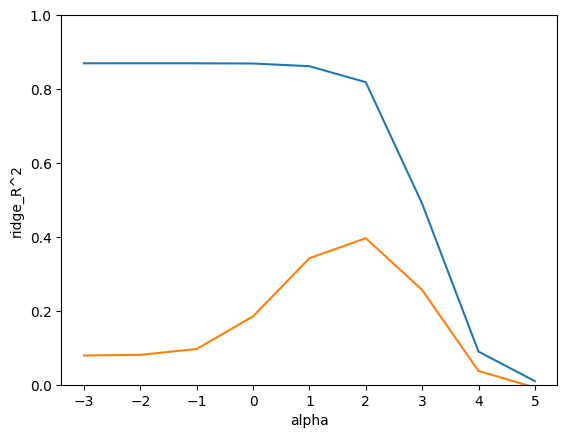

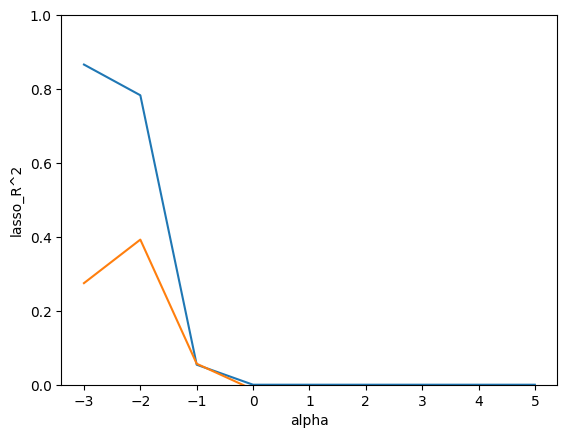

('cur', 'grade', 'pf')
0.04937040628966172
-1.9042562651895264e+27


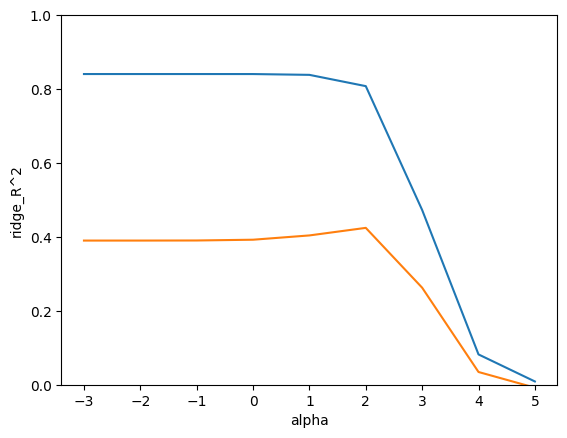

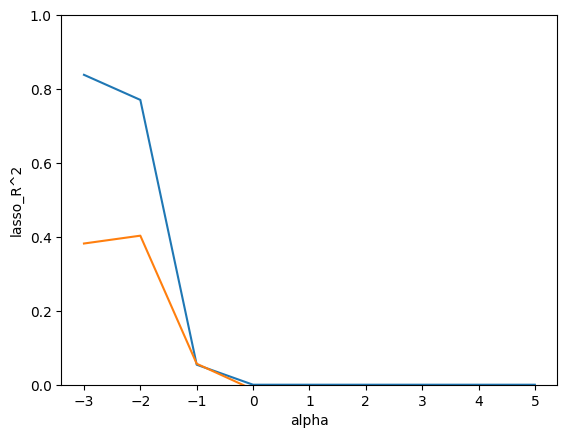

('major', 'cur', 'grade', 'pf')
-0.24757358255118644
-5.526992607563774e+27


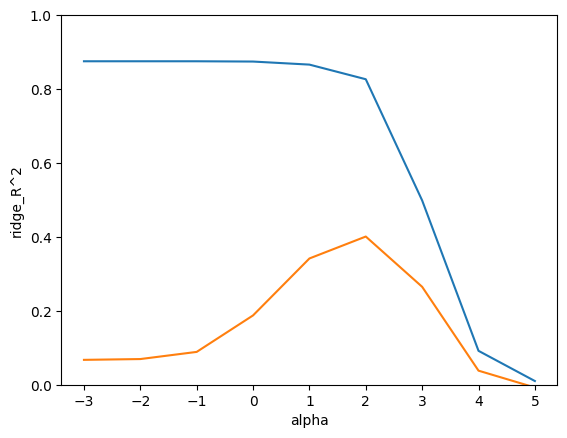

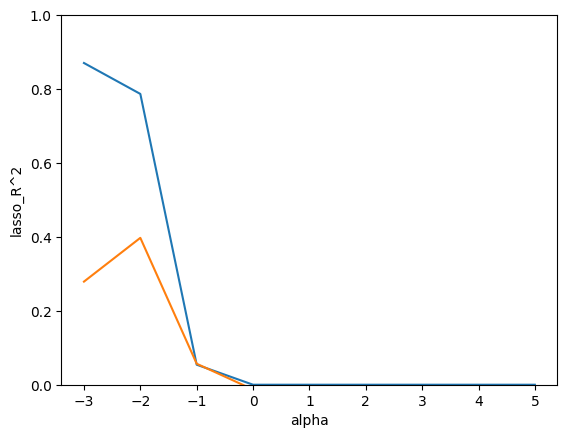

In [ ]:
# 전처리
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, LinearRegression, Lasso
import matplotlib.pyplot as plt
from itertools import combinations

df = pd.DataFrame(lectures)
df.columns = ["cur", "major", "id", "name", "num", "grade", "credit", "pf", "time", "eng", "score", "want", "hw", "team", "mark", "att", "test"]
df['score'] = [float(x) for x in df.score]
df = df[df.score != 0] # score가 없는 데이터 제외
df['grade'] = [int(x) if x != "" else 0 for x in df.grade ] # grade "" -> 0, "3.5" -> 3.5

# 모든 특성 조합 계산
features = ['major', 'cur', 'grade', 'pf']
features = list(combinations(features, 1)) + list(combinations(features, 2)) + list(combinations(features, 3)) + list(combinations(features, 4))


for feature in features:
  # 핫 원 인코딩
  print(feature)
  lecture_full = pd.get_dummies(df[list(feature)]) # features
  lecture_score = df['score'] # target

  # 훈련세트 테스트 세트 분할
  train_input, test_input, train_target, test_target = train_test_split(lecture_full, lecture_score, random_state=14)

  # 벡터 정규화
  ss = StandardScaler()
  ss.fit(train_input)
  train_scaled = ss.transform(train_input)
  test_scaled = ss.transform(test_input)

  # 단순 선형 회귀 - 특성이 너무 많아 과대적합현상
  lr = LinearRegression()
  lr.fit(train_scaled, train_target)

  print(lr.score(train_scaled, train_target)) # 학습 세트에 대한 결정계수(R^2)
  print(lr.score(test_scaled, test_target)) # 테스트 세트에 대한 결정계수(R^2)

  # 규제 선형 회귀(ridge 회귀, lasso 회귀)
  ridge_train_score = []
  ridge_test_score = []
  lasso_train_score = []
  lasso_test_score = []
  alpha_list = [10**(-3), 10**(-2), 10**(-1), 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]
  for alpha in alpha_list:
    ridge = Ridge(alpha=alpha)
    lasso = Lasso(alpha=alpha)
    lasso.fit(train_scaled, train_target)
    ridge.fit(train_scaled, train_target)
    ridge_train_score.append(ridge.score(train_scaled, train_target))
    ridge_test_score.append(ridge.score(test_scaled, test_target))
    lasso_train_score.append(lasso.score(train_scaled, train_target))
    lasso_test_score.append(lasso.score(test_scaled, test_target))

  plt.plot(np.log10(alpha_list), ridge_train_score)
  plt.plot(np.log10(alpha_list), ridge_test_score)
  plt.xlabel('alpha')
  plt.ylabel('ridge_R^2')
  plt.ylim([0, 1])
  plt.show()

  plt.plot(np.log10(alpha_list), lasso_train_score)
  plt.plot(np.log10(alpha_list), lasso_test_score)
  plt.xlabel('alpha')
  plt.ylabel('lasso_R^2')
  plt.ylim([0, 1])
  plt.show()


> 파란선 : 학습 케이스에 대한 결정계수
황색선 : 테스트 케이스에 대한 결정계수

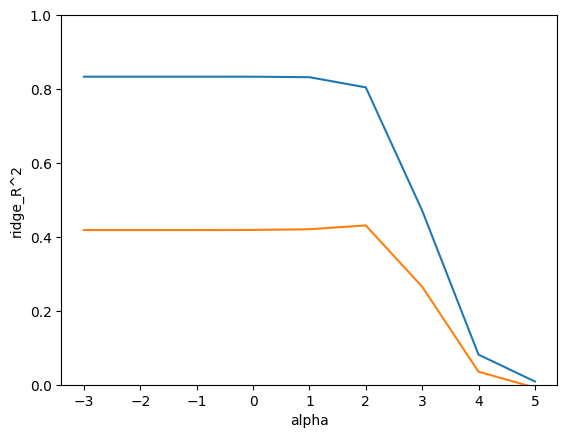

> 학습 모델의 경우 : 릿지회귀> 라쏘회귀 > 단순선형회귀

> 규제도의 경우 :  alpha 10^2의 값에서 가장 높은 결과를 보였다.

> 특성조합의 경우: 이수구분, 담당교수 조합이 가장 좋은 결과(R^2: 0.429)를 보였주었으며, ('major', 'cur', 'grade', 'pf'), ('cur', 'grade', 'pf')
, ('major', 'grade', 'pf'), ('major', 'cur', 'pf'), ('cur', 'pf'), ('major', 'pf') 해당 조합이 테스트에서 0.4이상의 결정계수를 가졌다. 이로서 담당교수가 중요한 특성이었음을 알 수 있다.

결론적으로 릿지회귀 모델에 규제도 alpha 10^2, ('cur', 'pf')특성을 적용하여 score값을 추론하기로 했다.

In [ ]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge


df = pd.DataFrame(lectures)
df.columns = ["cur", "major", "id", "name", "num", "grade", "credit", "pf", "time", "eng", "score", "want", "hw", "team", "mark", "att", "test"]
df['grade'] = [int(x) if x != "" else 0 for x in df.grade ] # grade "" -> 0, "3.5" -> 3.5
df['score'] = [float(x) for x in df.score]


train_df = pd.get_dummies(df[['cur', 'pf']])
train_df["score"] = df["score"]
train_df = train_df[train_df.score != 0] # score가 없는 데이터 제외



lecture_score = train_df.score # target
train_df.drop(['score'],axis=1)
lecture_full = train_df # features

train_input = lecture_full
train_target = lecture_score


ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)

# 모델 학습
ridge = Ridge(alpha=10**2)
ridge.fit(train_scaled, train_target)



predict_df = pd.get_dummies(df[['cur', 'pf']])
predict_df['score'] = df['score']
predict_df = predict_df[predict_df.score == 0] # score이 없는 데이터 모음
predict_df.drop(['score'],axis=1)

predict_scaled = ss.transform(predict_df)
result_score = []

for item in predict_scaled:
  result_score.append(*ridge.predict([item]))
print(f"예측값 평균: {sum(result_score)/len(result_score)}\n최댓값: {max(result_score)}\n최솟값: {min(result_score)}")

예측값 평균: 1.3163567607576443
최댓값: 1.5860171255856628
최솟값: 0.7945484555507516


<ipython-input-4-bc4fadb24825>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.score[i] = result_score.pop()


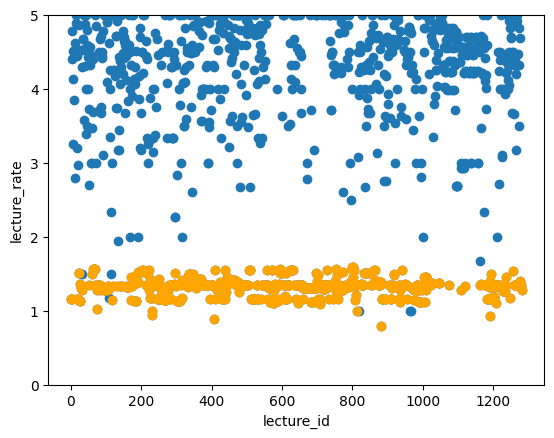

In [ ]:
result_score[::-1]
changed_index = []
for i in range(len(df.score)):
  if df.score[i] == 0:
    changed_index.append(i)
    df.score[i] = result_score.pop()

plt.scatter([i for i in range(len(df.score))], df.score)
for i in changed_index:
  plt.scatter(i, df.score[i], color='orange')
plt.ylabel('lecture_rate')
plt.xlabel('lecture_id')
plt.ylim([0,5])
plt.show()

> 데이터 개수가 너무 적어 다중 선형회귀 방식으로는 예상 평균 점수 1.31점이라는 지나치게 낮은 별점을 부여했다. 이는 원핫 인코딩과정에서 너무 다양한 특성이 생겨 선형회귀로는 적절한 값을 찾아주지 못하는 것으로 보인다. 따라서 k-최근접 이웃 회귀 모델을 활용해보았다.

> 주황색 점이 보정된 값을 의미한다.

#### k-최근접 이웃 회귀

In [ ]:
# 전처리
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from itertools import combinations

df = pd.DataFrame(lectures)
df.columns = ["cur", "major", "id", "name", "num", "grade", "credit", "pf", "time", "eng", "score", "want", "hw", "team", "mark", "att", "test"]
df['score'] = [float(x) for x in df.score]
df = df[df.score != 0] # score가 없는 데이터 제외
df['grade'] = [int(x) if x != "" else 0 for x in df.grade ] # grade "" -> 0, "3.5" -> 3.5
df = df.replace("", np.NaN) # 빈 문자열 Nan 처리


# 모든 특성 조합 계산
features = ['major', 'cur', 'grade', 'pf']
features = list(combinations(features, 1)) + list(combinations(features, 2)) + list(combinations(features, 3)) + list(combinations(features, 4))


for feature in features:
  # 핫 원 인코딩
  print(f"\n선택특성 {feature}\n")
  lecture_full = pd.get_dummies(df[list(feature)]) # features
  lecture_score = df['score'] # target

  # 훈련세트 테스트 세트 분할
  train_input, test_input, train_target, test_target = train_test_split(lecture_full, lecture_score, random_state=14)

  # 벡터 정규화
  ss = StandardScaler()
  ss.fit(train_input)
  train_scaled = ss.transform(train_input)
  test_scaled = ss.transform(test_input)

  for k in range(1, 5):

  # k - 최근접 이웃 모델
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(train_scaled, train_target)
    print(f"k : {k}")
    print(f"train(R^2) : {knr.score(train_scaled, train_target)}")
    print(f"test(R^2): {knr.score(test_scaled, test_target)}")


선택특성 ('major',)

k : 1
train(R^2) : -0.7110512782208387
test(R^2): -0.7162553920617651
k : 2
train(R^2) : -0.10568828799856456
test(R^2): -0.20500719263852063
k : 3
train(R^2) : -0.06622946952370601
test(R^2): -0.14209914039680305
k : 4
train(R^2) : -0.029144842060028653
test(R^2): -0.08994195087261336

선택특성 ('cur',)

k : 1
train(R^2) : -0.4108709666408892
test(R^2): -0.23066381549060888
k : 2
train(R^2) : -0.13328343221640004
test(R^2): -0.22278995503809274
k : 3
train(R^2) : -0.27448511858506186
test(R^2): -0.3661935456244698
k : 4
train(R^2) : -0.09421688021699759
test(R^2): -0.11936984720338395

선택특성 ('grade',)

k : 1
train(R^2) : -0.48811871531300044
test(R^2): -0.5777964213305855
k : 2
train(R^2) : -0.361677612577479
test(R^2): -0.31586730574159483
k : 3
train(R^2) : -0.37435812797686685
test(R^2): -0.3140651583925549
k : 4
train(R^2) : -0.15530963084086813
test(R^2): -0.08227160538618561

선택특성 ('pf',)

k : 1
train(R^2) : 0.672342869912677
test(R^2): 0.013830184311090066
k : 2
t

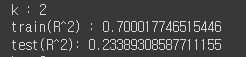

> 개설학과, 담당교수 특성에 이웃을 k = 2개로 설정했을때 결정계수가 0.3으로 가장 비슷한 예측값을 가진다.

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor


df = pd.DataFrame(lectures)
df.columns = ["cur", "major", "id", "name", "num", "grade", "credit", "pf", "time", "eng", "score", "want", "hw", "team", "mark", "att", "test"]
df['grade'] = [int(x) if x != "" else 0 for x in df.grade ] # grade "" -> 0, "3.5" -> 3.5
df['score'] = [float(x) for x in df.score]
df = df.replace("", np.NaN) # 빈 문자열 Nan 처리

ohe = OneHotEncoder(sparse=False)
ohe.fit(df[['pf', 'major']])

train_df = pd.DataFrame(ohe.transform(df[['pf', 'major']])) # 원핫 인코딩에서 아무것도 없는 것이 제일 많이 들어감
train_df["score"] = df["score"]
train_df = train_df[train_df.score != 0] # score가 없는 데이터 제외



lecture_score = train_df.score # target
train_df = train_df.drop(['score'],axis=1)
lecture_full = train_df # features

train_input = lecture_full
train_target = lecture_score


# 모델 학습
knr = KNeighborsRegressor(n_neighbors=2)
knr.fit(train_input.values, train_target)


predict_df = pd.DataFrame(ohe.transform(df[['pf', 'major']]))
predict_df['score'] = df['score']
predict_df = predict_df[predict_df.score == 0] # score이 없는 데이터 모음
predict_df = predict_df.drop(labels='score',axis=1)

result_score = []

for item in predict_df.to_numpy():

  result_score.append(*knr.predict([item])) # 예측

print(result_score)
print(f"예측값 평균: {sum(result_score)/len(result_score)}\n최댓값: {max(result_score)}\n최솟값: {min(result_score)}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[4.595000000000001, 4.595000000000001, 4.595000000000001, 4.595000000000001, 4.595000000000001, 4.595000000000001, 4.595000000000001, 4.595000000000001, 4.595000000000001, 4.595000000000001, 4.595000000000001, 4.46, 4.015000000000001, 4.5, 4.45, 3.665, 3.665, 3.665, 3.665, 3.665, 4.45, 4.45, 4.45, 4.45, 4.45, 4.13, 3.375, 4.45, 4.45, 4.195, 4.195, 3.675, 3.675, 3.675, 3.675, 3.675, 4.25, 4.195, 4.25, 4.8100000000000005, 4.195, 4.195, 4.1899999999999995, 4.1899999999999995, 4.5600000000000005, 4.355, 4.355, 4.355, 4.355, 4.355, 4.355, 4.355, 4.355, 4.205, 4.355, 4.0, 4.0, 4.0, 4.015, 4.015, 4.015, 4.015, 4.015, 4.0, 4.0, 4.0, 4.425000000000001, 4.425000000000001, 4.425000000000001, 4.425000000000001, 4.425000000000001, 4.545, 3.44, 4.545, 4.545, 4.545, 4.545, 3.44, 3.44, 3.44, 3.44, 3.44, 4.545, 4.545, 4.545, 4.545, 4.545, 3.95, 4.57, 4.57, 4.595000000000001, 4.25, 4.25, 4.25, 4.595000000000001, 4.595000000000001, 3.33, 4.415, 4.595000000000001, 4.595000000000001, 4.220000000000001, 4.5

유의미한 편차를 보여주며, 예측값 평균 또한 이해가 가는 수치로 얻을 수 있었다.

<ipython-input-4-619e7f0bd926>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.score[i] = result_score.pop()


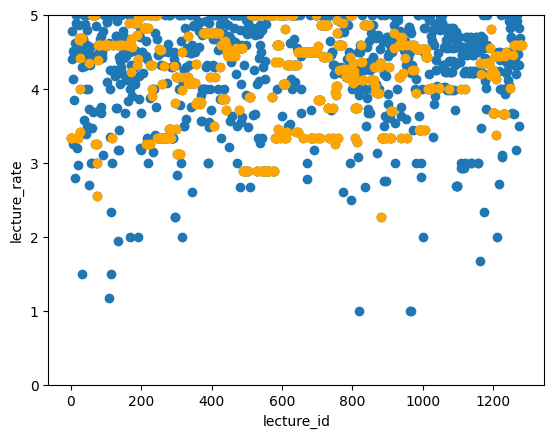

In [ ]:
result_score[::-1]

changed_index = []
for i in range(len(df.score)):
  if df.score[i] == 0:
    changed_index.append(i)
    df.score[i] = result_score.pop()

plt.scatter([i for i in range(len(df.score))], df.score)
for i in changed_index:
  plt.scatter(i, df.score[i], color='orange')
plt.ylabel('lecture_rate')
plt.xlabel('lecture_id')
plt.ylim([0,5])
plt.show()

> 강의평 결측치가 해결되었다. 변경 데이터는 황색점으로 표시

# 추천시스템 개발
- 실제로 개발 가능한 모델 or 간단한 예시 형태로 문제별 모델 제시

## 사용자-강의 간 유사도 측정

현재 바로 활용할 수 있는 사용자의 특성과 강의 특성간의 연관 데이터가 없으므로, 가톨릭대 학생들에게 본인이 강의를 선정하는 과정을 물어보고 본 떠 모델을 개발하기로 하였다.

- A 결정과정
1. 에브리타임에서 본인 전공, 학년에 맞는 강의 필터링
2. 똑같은 이름의 강의의 경우 별점 순으로 높은 강의 선택(4점대 이상부터는 중요하게 안보는 성향)
3. 관심없는 강의 위주로 제외하며 시간표 배치

- B 결정과정
1. 본인 학년에 들어야하는 졸업요건 강의 우선 선정, 전공과 학년에 맞는 강의 필터링
2. 에브리타임 과목별 강의평 파악하여 필터링
3. 부족한 학점이 있는 경우 타과나 자유교양에서 선택(개인적으로 이 과정에서 고민이 많이 발생)

- C 결정과정
1. 에브리타임에서 수강할 강의들을 확인
2. 수강할 과목들로 시간표 배치가 말이 되는지 확인
3. 수강실패에 대비하여 다른 강의들을 찾아봄

- D 결정과정
1. 졸업요건에 해당하는 강의우선 선정
2. 본인 흥미에 맞는 강의 선택
3. 별점을 기준으로 선택
4. 시간표에 맞게 배치

해당 과정에서 공통적으로 들어가는 선택지를 정리해보았다.

- 통합 결정과정
1. 졸업 필수 이수 강의 선택
2. 본인의 전공에 맞는 강의 선택
3. 본인의 학년에 맞는 강의 선택
4. 위 상관관계를 따르되 모든 강의는 에브리타임 강의평 점수가 높은 강의를 선호(교양과목 포함)

통합 해결과정을 보면 다양한 특성들을 계층구조로 두고 판단하고 있다.


### 유사도 측정

특성들의 유사도 측정 알고리즘으로는 유클리드 거리를 사용하기로 하였다. 또한 통합해결과정에서 보았듯 다양한 특성들이 계층구조로 되어있기 때문에 별도의 수식으로 가중치를 부여할 것이다.

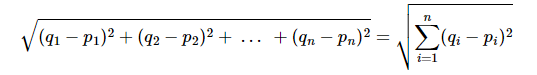

> 유클리드 거리 계산법은 두 점의 좌표 간 거리를 계산해주는 수식이다.

> 본 연구에서는 두 벡터간 거리를 기반으로 한 유사도 계산에 사용할 것이다.

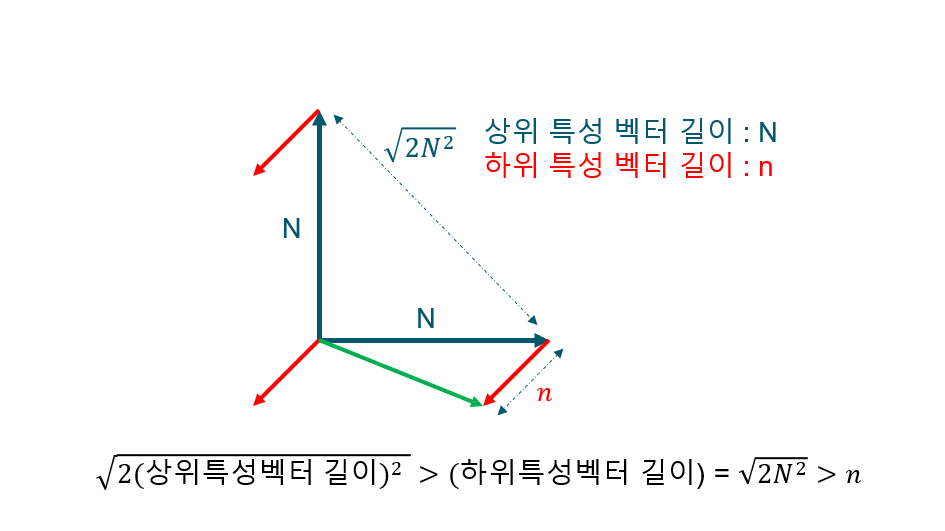


> 특성들이 필수이수강의 > 전공강의 > 이수학년 강의 > 강의평이 좋은 강의 순의 계층 구조를 보이고 있다. 따라서 유클리드 거리 계산 시 계층구조에 맞춰 가중치를 줄 수 있는 최소조건을 직접 계산했다.

> 결과 유사도는 1\~0의 값을 가지며 필수이수강의의 경우 1로 고정 값을 가지고 전공강의, 이수학년, 강의평은 위 최소식을 만족하는 각각 3, 3\~2, 1\~0 의 길이를 적용하여 벡터화하여 사용자 벡터와 비교해 유사도를 계산했다.

각 특성벡터의 가중치 계산식은 아래와 같다
- 전공강의 벡터 : 원핫인코딩 적용 후  * 3 (길이 3)
- 이수학년 벡터 : 이수학년 / 4 + 2 (길이 3 ~ 2)
- 강의평 벡터 : 강의평 / 5 (길이 1 ~ 0)

이수학년 벡터는 특히 비슷한 학년간 연속적인 연관성이 있는 점을 반영하였다.

### 코드

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# 사용자 특성 입력
student_grade = 2 # 학년
student_major = "컴퓨터정보공학부" # 전공
student_essential = ["그리스도교사상과문화", "사랑나누기", "일반수학2및연습"] # 필수 이수 강의
# 이수 완료 강의
student_taked = ["컴퓨터와프로그래밍2", "일본어학입문", "법학개론", "경제학개론", "키스톤디자인ㆍ창의설계", "인간학2", "일어1", "일반물리학및실험1", "일반수학1및연습", "선형대수학", "운영체제", "자료구조기초", "논리회로및설계", "인공지능프로그래밍설계", "사이버스페이스의정보윤리"]


# 전처리
major_ohe = OneHotEncoder(sparse=False)
major_ohe.fit(df[['major']])


# 강의 벡터
target_df = pd.concat([pd.DataFrame(major_ohe.transform(df[['major']])) * 3,  df[['grade']]/4 + 2], axis = 1)
target_df['score'] = df['score'] / 5 # 0~1의 값을 가지도록 표준화

# 사용자 벡터
student_vec = 0

student_vec = pd.concat([pd.DataFrame(major_ohe.transform(pd.DataFrame([student_major]))) * 3, pd.DataFrame([student_grade])/4 + 2], axis = 1)
student_vec['score'] = 1 # 강의평이 최대한 좋은 값을 찾도록 설정
student_vec = student_vec.to_numpy()

# 유클리드 거리계산
dist = []
for i in range(0, target_df.shape[0]):
  lecture_vec = target_df.iloc[i].to_numpy()
  dist.append(np.linalg.norm(student_vec - lecture_vec))

# 결과 df
result_df = df
result_df['dist'] = pd.DataFrame(dist, columns=['dist'])

# 필수이수과목 거리 0 처리 + 이수완료강의 행 제거
for i in range(0, result_df.shape[0]):
  if result_df['name'][i] in student_essential : result_df['dist'][i] = 0
  if result_df['name'][i] in student_taked : result_df = result_df.drop(i, axis=0)

print(max(dist))
print(min(dist))
result_df


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


4.371676566261507
0.03200000000000003


<ipython-input-5-2b284015de2e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if result_df['name'][i] in student_essential : result_df['dist'][i] = 0
<ipython-input-5-2b284015de2e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if result_df['name'][i] in student_essential : result_df['dist'][i] = 0


,cur,major,id,name,num,grade,credit,pf,time,eng,score,want,hw,team,mark,att,test,dist
0,전공기초,IT파이낸스학과,07023,기초파이낸스,01,1,3,허성준,"[수11, 수12, 수13]",NaN,3.330,5,NaN,NaN,NaN,NaN,NaN,4.263104
1,제1전공필수,IT파이낸스학과,07014,IT파이낸스프로그래밍,01,2,3,김수원,"[토4, 토5, 토6]",NaN,3.330,3,NaN,NaN,NaN,NaN,NaN,4.255767
2,제1전공선택,IT파이낸스학과,07020,회계학의이해2,01,1,3,김미옥,"[토1, 토2, 토3]",NaN,3.330,2,NaN,NaN,NaN,NaN,NaN,4.263104
3,자유선택교양,경영학과,05214,금융시장의이해,01,0,3,이재영,"[화2, 화3, 목3]",NaN,4.410,14,1.0,0.0,1.0,0.0,-2.0,4.273631
4,전공기초,경영학과,00080,경영학원론,01,0,3,홍기석,"[수1, 금1, 금2]",NaN,4.780,88,0.0,-1.0,1.0,1.0,1.0,4.272228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,제1전공선택,회계학과,06611,회계학현장실습Ⅰ,01,4,3,NaN,NaN,NaN,4.595,0,NaN,NaN,NaN,NaN,NaN,4.272770
1279,제1전공선택,회계학과,06612,회계학현장실습Ⅱ,01,4,3,NaN,NaN,NaN,4.595,0,NaN,NaN,NaN,NaN,NaN,4.272770
1280,제1전공선택,회계학과,06613,회계학현장실습Ⅲ,01,4,3,NaN,NaN,NaN,4.595,0,NaN,NaN,NaN,NaN,NaN,4.272770
1281,제1전공선택,회계학과,06614,회계학현장실습Ⅳ,01,4,3,NaN,NaN,NaN,4.595,0,NaN,NaN,NaN,NaN,NaN,4.272770


In [ ]:
# df 파일로 저장
result_df.to_csv('data.csv', sep=',', na_rep='NaN', index=False)

> 안정적으로 특성들을 고려하여 추천해주는 것을 확인 할 수 있다. dist 값이 작을수록 추천도가 높은 값이다.

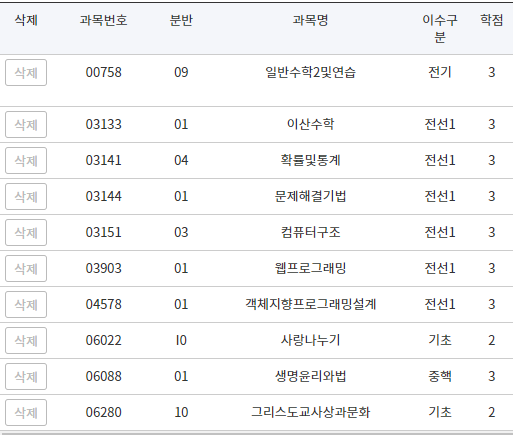

> 비교해보면 실제로 담은 강의들이 우선 순위가 높은 것을 확인 할 수 있다.

## 협업 필터링 모델

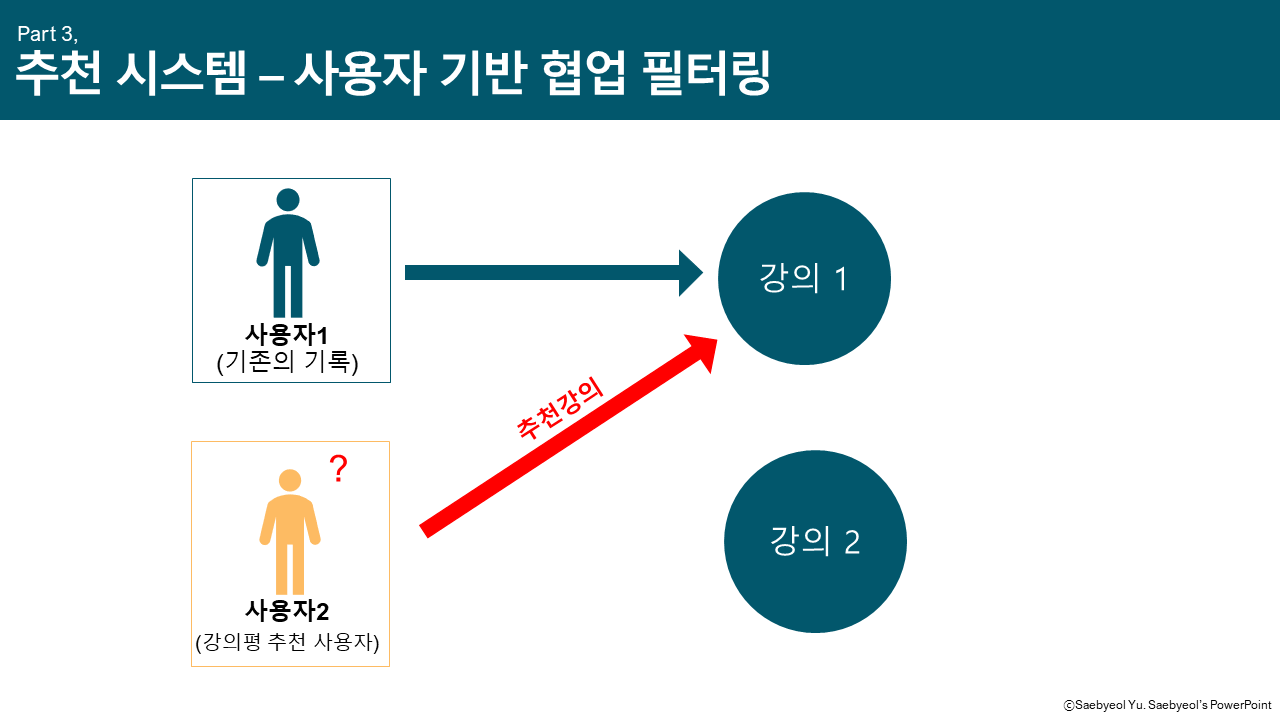

위와 같은 모델은 개인의 특성을 충분히 반영한 시간표 추천이 될 수 없다. 또한 변화하는 학생들의 강의선택 트랜드를 반영하기 어려울 것이다. 따라서 트리니티 api를 통해 학생들의 수강신청 기록을 받아 올 수 있는 상황을 가정하여 협업 필터링 모델도 구현해보았다. 데이터는 더미 데이터로 대체하였다.

https://colab.research.google.com/drive/18iIPvATOZnFcymue-EXB2KaQ20zfqw5x?usp=sharing#scrollTo=uEQS9W-lkyC1

# 시간표 문제

구글의 조합 최적화 문제를 해결할 수 있도록 해주는 오픈소스 'ortools'라이브러리를 활용하였다. 정수 계획법을 활용하여 최적해를 찾아준다.

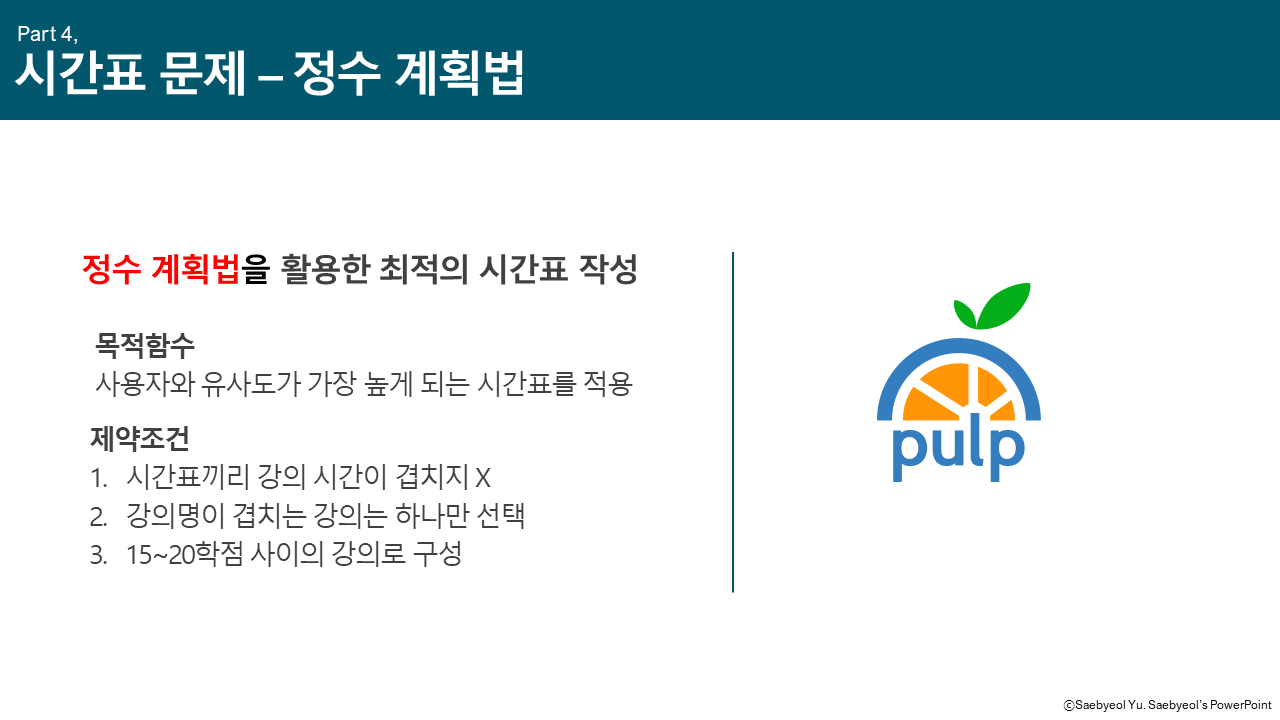

규칙목록
1. 시간표가 겹치지 않도록 배치한다.
2. 15~20학점 사이로 강의를 선정한다.
3. 이름이 중복되는 강의는 수강하지 않는다.
4. 최대한 수강자와 근접한 강의들로 시간표를 만든다.

In [ ]:
!pip install --target=$my_path yfinance pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 112.5 MB/s eta 0:00:00


In [ ]:
import ast
import pandas as pd
import pulp

# CSV 파일에서 데이터를 로드합니다.
df_time = pd.read_csv('data.csv', converters={'id': str})
df_time['time'] = df_time['time'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# 'name', 'time', 'dist', 'id', 'num' 열만 선택합니다.
df_time = df_time[['name', 'time', 'dist', 'id', 'num']]

# 각 행을 딕셔너리로 변환하고, 각 행의 'time' 리스트를 키로 사용합니다.
classes = {row['name']: {'times': row['time'], 'score': row['dist'], 'id': row['id' ], 'num': row['num']} for _, row in df_time.iterrows()}

# 강의들의 집합을 생성합니다.
class_names = set(classes.keys())

# 각 강의를 선택할지 여부를 나타내는 이진 변수를 생성합니다.
x = pulp.LpVariable.dicts('class', class_names, cat='Binary')

# 문제를 정의합니다. 여기서는 점수를 최소화하도록 설정합니다.
problem = pulp.LpProblem("Class_Scheduling", pulp.LpMinimize)

# 목적 함수를 정의합니다. 이 함수는 선택된 강의들의 점수의 합입니다.
problem += pulp.lpSum([x[i]*classes[i]['score'] for i in class_names])

# 제약 조건을 추가합니다. 각강의 시간대에 겹치는 강의들은 동시에 선택할 수 없습니다.
for class_name in class_names:
    for time in classes[class_name]['times']:
        problem += pulp.lpSum([x[i] for i in class_names if time in classes[i]['times']]) <= 1

# 최소 강의 수 제약 조건을 추가합니다.
problem += pulp.lpSum([x[i] for i in class_names]) >= 7  # 예를 들어, 최소 5개의 강의를 선택해야 한다고 가정합니다.

# 문제를 풀고 결과를 출력합니다.
problem.solve()
print("Status:", pulp.LpStatus[problem.status])

# 선택된 강의들과 해당 강의들의 시간표를 출력합니다.
for v in problem.variables():
    if v.varValue > 0:
        print(classes[v.name[6:]]['id'], "-", classes[v.name[6:]]['num'], v.name, "times:", classes[v.name[6:]]['times'], "score:", classes[v.name[6:]]['score'])

# 총 점수를 출력합니다.
print("Total score: ", pulp.value(problem.objective))

Status: Optimal
04578 - 01 class_객체지향프로그래밍설계 times: ['수1', '수2', '수3'] score: 0.134
03144 - 01 class_문제해결기법 times: ['화2', '화3', '목3'] score: 0.042
06022 - I0 class_사랑나누기 times: ['금5', '금6'] score: 0.0
04571 - 02 class_시스템소프트웨어실습 times: ['금7', '금8', '금9', '금10'] score: 0.032
03903 - 01 class_웹프로그래밍 times: ['금1', '금2', '금3', '금4'] score: 0.04
00758 - 09 class_일반수학2및연습 times: ['월6', '월7', '수5', '수6', '수7'] score: 0.0
03141 - 04 class_확률및통계 times: ['화6', '목1', '목2'] score: 0.172
Total score:  0.41999999999999993


# 결과물

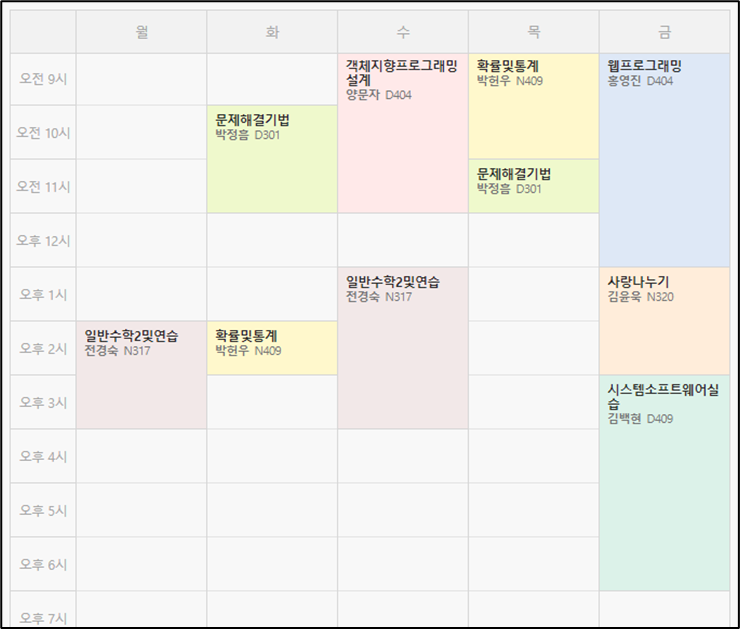

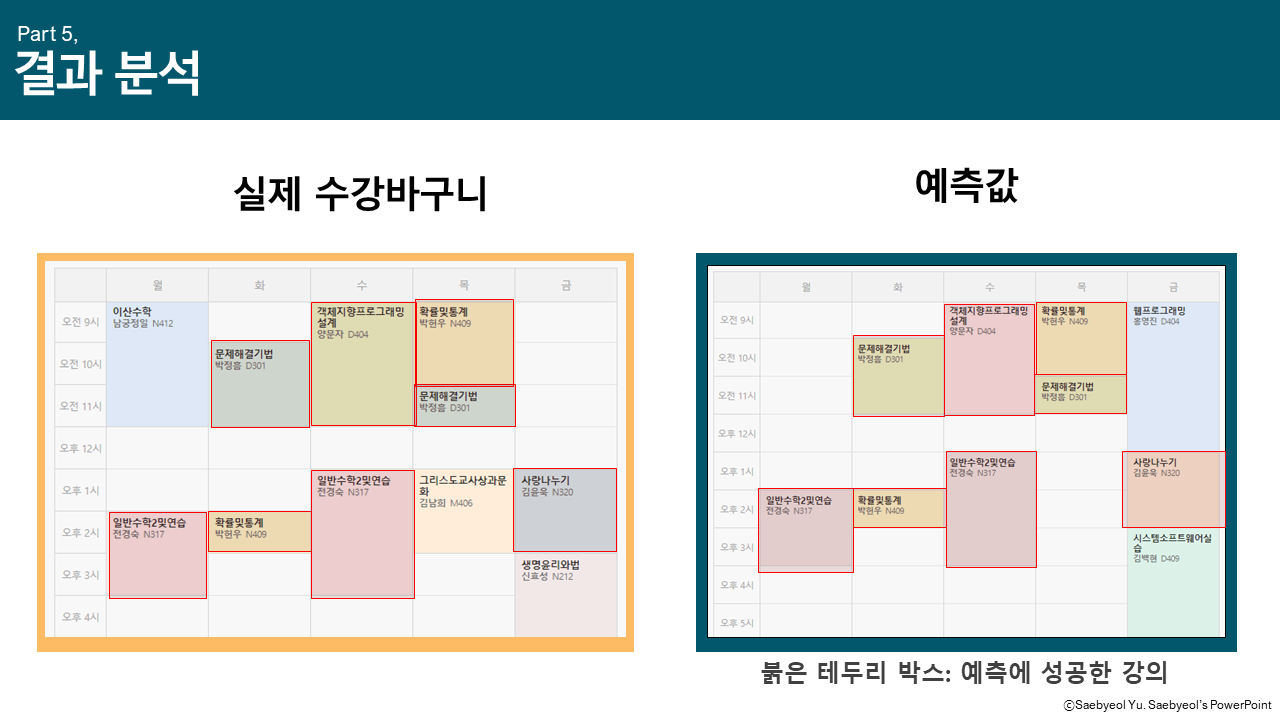

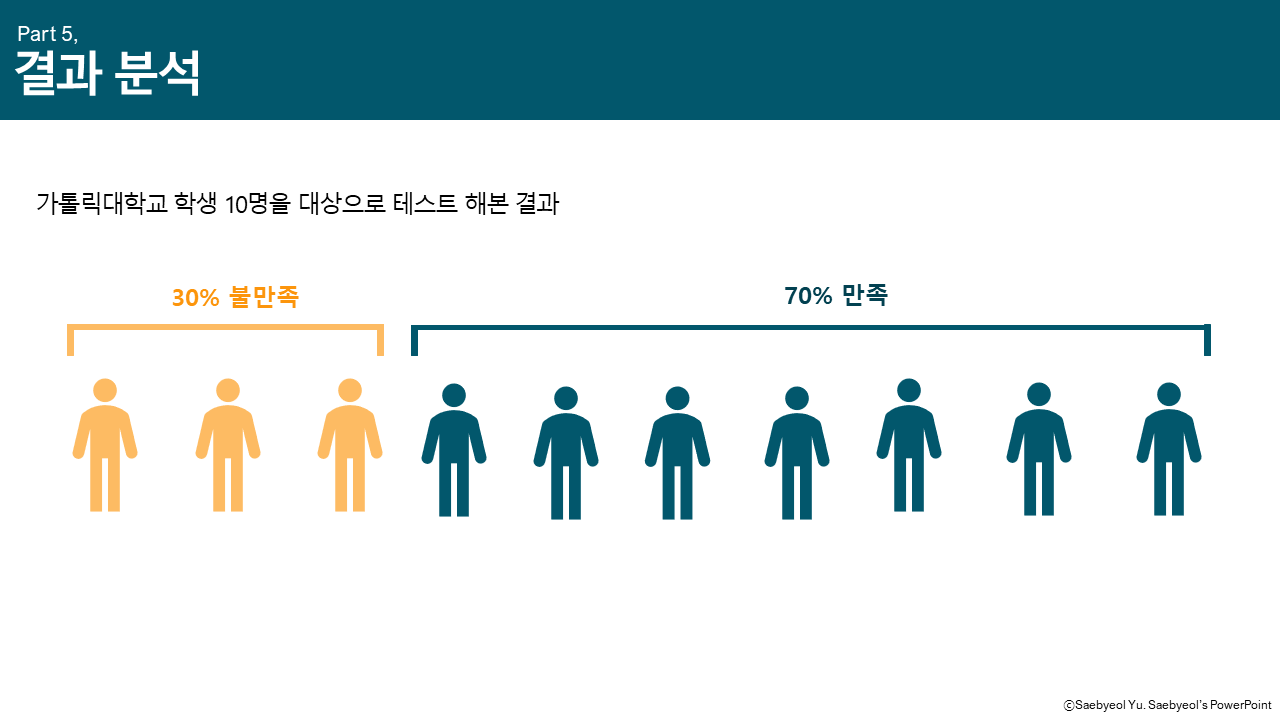

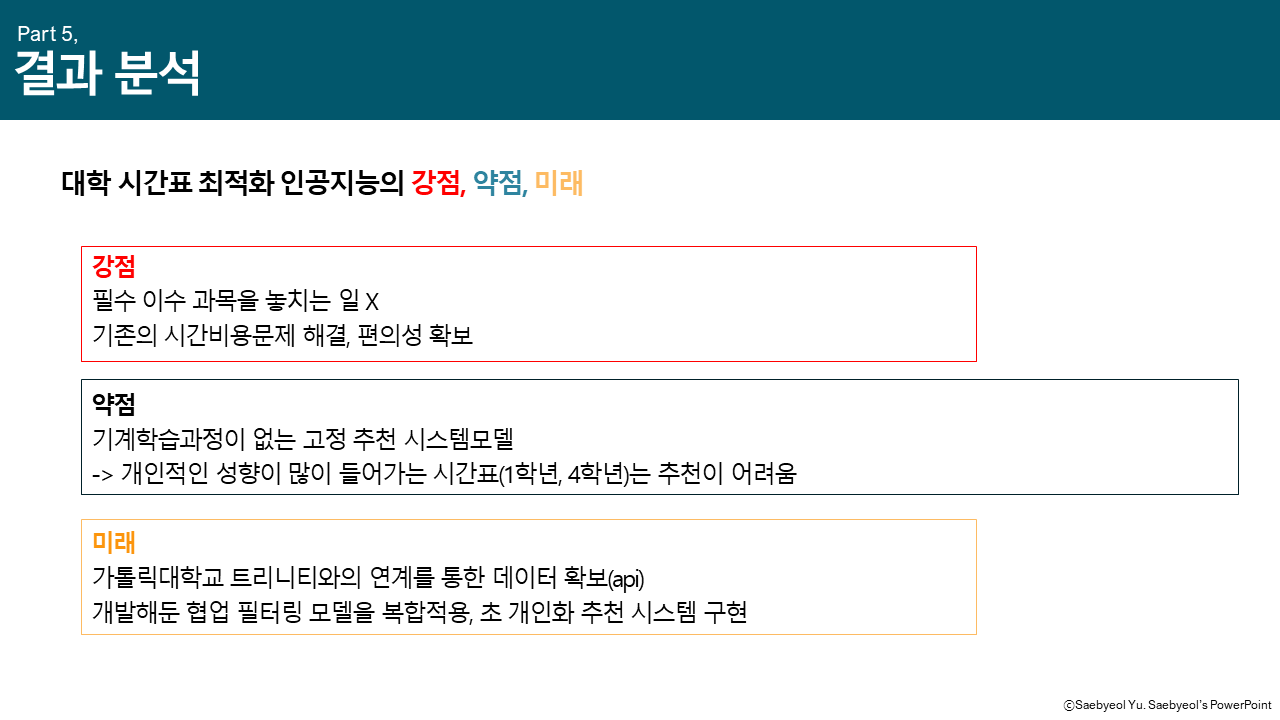